## Benchmark for measuring performance of engineered features and models
Add station flow to benchmark_1

In [2]:
import os
if os.name=='nt':
    mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
    os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sys import getsizeof
import time
import gc

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
import pickle

def save_pickle(x, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(x, handle, protocol=pickle.HIGHEST_PROTOCOL)

def read_pickle(filename):
    with open(filename, 'rb') as handle:
        x = pickle.load(handle)
    return x

In [4]:
from numba import jit

@jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)

@jit
def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    new_mcc = 0
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_mcc
    
def mcc_eval(y_prob, dtrain):
    y_true = dtrain.get_label()
    best_mcc = eval_mcc(y_true, y_prob)
    return 'MCC', -best_mcc

In [5]:
def cross_val_predict_rskf(clf, x_train, y_train, n_splits=3, 
                           n_repeats=2, random_state=42, verbose=False):
    '''
    Repeated stratified KFold CV, returns predictions for 
    each repeat and average score.
    n_repeats: repetitions of CV
    '''
    scores = []
    n_trees = []
    clfs = []
    running_time = []
    
    rskf = RepeatedStratifiedKFold(n_repeats=n_repeats, n_splits=n_splits, 
                                   random_state=0)
    np.random.seed(random_state)
    for n, (train_index, test_index) in enumerate(rskf.split(x_train, y_train)):
        start_time = time.time()
        x_train_tmp, x_test_tmp = x_train.iloc[train_index], x_train.iloc[test_index]
        y_train_tmp, y_test_tmp = y_train.iloc[train_index], y_train.iloc[test_index]

        clf.random_state = np.random.randint(10000000)

        clf.fit(x_train_tmp, y_train_tmp, 
                eval_set=[(x_test_tmp, y_test_tmp)], 
                eval_metric=mcc_eval, early_stopping_rounds=10,
                verbose=verbose)
        scores.append(-clf.best_score)
        n_trees.append(clf.best_ntree_limit)
        clfs.append(clf)
        running_time.append(time.time()-start_time)
        print('Split {}, score = {:.3f}, best_ntree_limit = {}, total time = {:.3f} min'.format(n, scores[n], 
            clf.best_ntree_limit, sum(running_time)/60))

    print('Score mean = {:.3f}, std = {:.3f}'.format(np.mean(scores), np.std(scores)))
    
    return clfs, scores, n_trees, running_time

In [6]:
def cross_val_predict_skf_rm(clf, x_train, y_train, n_splits=3, 
                           n_repeats=2, random_state=42, verbose=False):
    '''
    Stratified KFold CV with repeated models
    '''
    scores = []
    n_trees = []
    clfs = []
    running_time = []

    skf = StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True)
    np.random.seed(random_state)

    for m in range(n_repeats):
        print('Repeat {}'.format(m))
        for n, (train_index, test_index) in enumerate(skf.split(x_train, y_train)):
            start_time = time.time()
            x_train_tmp, x_test_tmp = x_train.iloc[train_index], x_train.iloc[test_index]
            y_train_tmp, y_test_tmp = y_train.iloc[train_index], y_train.iloc[test_index]

            clf.random_state = np.random.randint(10000000)
            # print(clf.random_state)

            clf.fit(x_train_tmp, y_train_tmp, 
                    eval_set=[(x_test_tmp, y_test_tmp)], 
                    eval_metric=mcc_eval, early_stopping_rounds=10,
                    verbose=verbose)
            n_trees.append(clf.best_ntree_limit)
            scores.append(-clf.best_score)
            clfs.append(clf)
            running_time.append(time.time() - start_time)
            print('Split {}, score = {:.3f}, n_best_trees = {}, total time = {:.3f} min'.format(n, 
                scores[m*n_repeats+n], clf.best_ntree_limit, sum(running_time)/60))

    print('Score mean = {:.3f}, std = {:.3f}'.format(np.mean(scores), np.std(scores)))
    
    return clfs, scores, n_trees, running_time

In [7]:
# y_train = read_pickle('y_train.pickle')

# x_train = read_pickle('x_train_numeric_date_0.pickle')

In [8]:
important_features = pd.read_csv('important_numeric_features.csv', index_col=0, header=None)
important_features = list(important_features.values.ravel())
important_features.extend(['Id', 'Response'])

In [9]:
x_train_numeric = pd.read_csv('data/train_numeric.csv.zip', index_col=0, usecols=important_features)

y_train = x_train_numeric.Response
x_train_numeric.drop(['Response'], axis=1, inplace=True)

In [61]:
date_train = pd.read_csv('train_station_flow.csv.gz', index_col=0, header=None)

In [62]:
x_train = x_train_numeric.join(date_train)

columns = list(x_train.columns)
columns[-1] = 'station_flow'
x_train.columns = columns

### Compare variance of CV score between repeated stratified KFold and stratified KFold with repeated models

In [71]:
n_estimators = 200
clf = XGBClassifier(max_depth=14, n_estimators=n_estimators, 
                    base_score=0.0058, n_jobs=-1, colsample_bytree=0.6,
                    min_child_weight=5, subsample=0.9,  
                    reg_lambda=4, silent=False, learning_rate=0.03)

In [72]:
# clfs, scores, n_trees, running_time = cross_val_predict_rskf(clf, x_train_numeric, 
#    y_train, n_splits=3, n_repeats=2, random_state=42, verbose=False)

In [74]:
clfs, scores, n_trees, running_time = cross_val_predict_skf_rm(clf, x_train, 
    y_train, n_splits=5, n_repeats=3, random_state=42)
save_pickle(clfs, 'clfs_benchmark_2_flow_analysis.pickle')

Repeat 0
Split 0, score = 0.220, n_best_trees = 36, total time = 1.784 min
Split 1, score = 0.231, n_best_trees = 40, total time = 3.715 min
Split 2, score = 0.231, n_best_trees = 54, total time = 6.159 min
Split 3, score = 0.227, n_best_trees = 33, total time = 7.803 min
Split 4, score = 0.233, n_best_trees = 23, total time = 9.092 min
Repeat 1
Split 0, score = 0.227, n_best_trees = 40, total time = 11.021 min
Split 1, score = 0.233, n_best_trees = 16, total time = 12.049 min
Split 2, score = 0.222, n_best_trees = 18, total time = 13.152 min
Split 3, score = 0.217, n_best_trees = 49, total time = 15.379 min
Split 4, score = 0.226, n_best_trees = 21, total time = 16.593 min
Repeat 2
Split 0, score = 0.217, n_best_trees = 7, total time = 17.286 min
Split 1, score = 0.226, n_best_trees = 69, total time = 20.305 min
Split 2, score = 0.232, n_best_trees = 28, total time = 21.766 min
Split 3, score = 0.228, n_best_trees = 49, total time = 23.990 min
Split 4, score = 0.214, n_best_trees = 16

In [77]:
results = {'clfs': clfs, 'scores': scores, 'n_trees': n_trees, 'running_time': running_time}
save_pickle(results, 'results_benchmark_2_flow_analysis.pickle')

### Calculate `n_trees` for training the whole dataset

In [78]:
results = read_pickle('results_benchmark_2_flow_analysis.pickle')

In [88]:
n_rounds = np.ceil(np.mean(results['n_trees'])*5/4).astype(np.int)

In [89]:
np.mean(results['scores'])

0.22643846666666667

### Train on the whole dataset

In [90]:
clf = XGBClassifier(max_depth=14, n_estimators=n_rounds, 
                    base_score=0.0058, n_jobs=-1, colsample_bytree=0.6,
                    min_child_weight=5, subsample=0.9,  
                    reg_lambda=4, silent=False, learning_rate=0.03)
clf.fit(x_train, y_train, 
        eval_set=[(x_train, y_train)], 
        eval_metric=mcc_eval, verbose=True)

[0]	validation_0-error:0.005811	validation_0-MCC:-0.171849
[1]	validation_0-error:0.005811	validation_0-MCC:-0.182925
[2]	validation_0-error:0.005811	validation_0-MCC:-0.189521
[3]	validation_0-error:0.005811	validation_0-MCC:-0.191187
[4]	validation_0-error:0.005811	validation_0-MCC:-0.197343
[5]	validation_0-error:0.005811	validation_0-MCC:-0.211479
[6]	validation_0-error:0.005811	validation_0-MCC:-0.220852
[7]	validation_0-error:0.005811	validation_0-MCC:-0.223253
[8]	validation_0-error:0.005811	validation_0-MCC:-0.224446
[9]	validation_0-error:0.005811	validation_0-MCC:-0.226571
[10]	validation_0-error:0.005811	validation_0-MCC:-0.228607
[11]	validation_0-error:0.005811	validation_0-MCC:-0.232346
[12]	validation_0-error:0.005811	validation_0-MCC:-0.234033
[13]	validation_0-error:0.005811	validation_0-MCC:-0.237179
[14]	validation_0-error:0.005811	validation_0-MCC:-0.241221
[15]	validation_0-error:0.005811	validation_0-MCC:-0.241456
[16]	validation_0-error:0.005811	validation_0-MCC:

XGBClassifier(base_score=0.0058, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=14, min_child_weight=5, missing=None, n_estimators=42,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=4, scale_pos_weight=1,
       seed=None, silent=False, subsample=0.9)

In [97]:
y_train_pred = clf.predict_proba(x_train)[:, 1]

0.2929726104775557


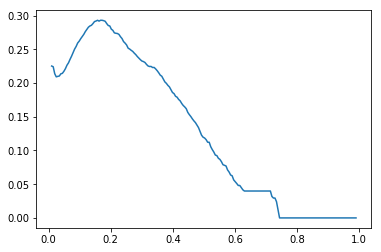

In [98]:
thresholds = np.linspace(0.01, 0.99, 200)
mcc = np.array([matthews_corrcoef(y_train, y_train_pred>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [99]:
best_threshold

0.16758793969849248

### Load test data and predict

In [95]:
important_features = important_features.remove('Response') if 'Response' in important_features else important_features

In [96]:
x_test = pd.read_csv('data/test_numeric.csv.zip', index_col=0, usecols=important_features)

date_test = pd.read_csv('test_station_flow.csv.gz', index_col=0, header=None)
x_test = x_test.join(date_test)
x_test.columns = columns

In [100]:
y_test_pred = clf.predict_proba(x_test)[:, 1]
y_test_pred_int = (y_test_pred>best_threshold).astype(int)

In [101]:
sub = pd.read_csv("data/sample_submission.csv.zip", index_col=0)
sub["Response"] = y_test_pred_int
sub.to_csv("15-benchmark_2_flow_analysis_submission.csv.gz", compression="gzip")

public MCC = 0.22579, private MCC = 0.21225

CV MCC mean = 0.22643, std = 0.009

**Hyperparameter tuning is needed!**